# The Great and Wonderful Beer Machine 
----
### Goal:
For my project, I will build a model that can accurately predict how a beer will be rated on the social media platform, Untappd. As seen in the pane below, a beer's average rating is on a scale of 0.25 - 5.0 (a beer cannot actually be rated zero).

![](it2_screenshot.png)

### Methodology:
In order to acquire my data, I will be scraping every unique beer page on Untappd and the corresponding brewery pages for both the average ratings of those beers and information about them with which to generate predictive features. I am using a combination of the [Requests](http://docs.python-requests.org/en/master/) and [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) libraries. Given the size of my data, I have thus far been storing it in CSVs, but I am considering setting up a PostgreSQL database if necessary.

Given that I am attempting to predict a rating, I intend implement a variety of regression models and compare their performance using [Scikit-Learn](http://scikit-learn.org/stable/), a premier machine learning library. The ease of interpreting a model is a recurring concern in machine learning applications. The transparency of a regularized linear regresssion is ideal for ascertaining the precise relationship a given feature has with the target variable and the relative significance features have compared to one another. Ensemble modeling techniques--like Random Forests and Gradient Boosted Regression--often provide greater accuracy at the expense of transparency. Depending on the relative strength of the model, I will weigh accuracy against opacity in determining the final model to use.

### The Data:
Below, you will find preliminary data analysis performed on the first 150,000 rows of data scraped from Untappd. I am currently in the process of scraping through all of the 2,000,000 rows. Given that the data is user-generated--by both consumers as well as breweries and venues--there is significant risk of messy data. I am also assuming that the features gleaned from Untappd--beer style, abv, ibu, number of check-ins, number of ratings, brewery location, etc--will be predictive of a beer's rating. 

Should these features prove insufficient, I see a few alternative paths forward:
1. Engineering more features, potentially with data from other sources, and entity matching those features to the existing entries
2. Drawing a threshold of high-rated vs. low-rated and experimenting with classification algorithms
3. Subset the data as necessary to improve the results or the viability of either option 1 or 2

### Success Criterion:
A successful project will culminate in a model with a robust r^2 score on data it has never before seen, indicating that it can predict the scores a new beer will have before that beer is rated. 

## Exploratory data analysis follows:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import sys

In [2]:
pd.options.display.max_rows = 200

In [3]:
def bleach(string):
    temp = ""
    string = str(string)
    if 'M' in string:
        for i in string:
            if i in ["1","2","3","4","5","6","7","8","9","0", "."]:
                temp += i
        if len(temp) > 0:
            return float(temp) * 1000000
    else:
        for i in string:
            if i in ["1","2","3","4","5","6","7","8","9","0", "."]:
                temp += i
        if len(temp) > 0:
            return float(temp)
        

In [4]:
beers = pd.read_csv('data/master_untappd_data.csv')

In [5]:
beers.shape

(148913, 16)

In [6]:
beers.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'abv', 'beer_id', 'brewery', 'brewery_id',
       'date_added', 'description', 'ibu', 'monthly_checkins', 'name',
       'raters', 'rating', 'style', 'total_checkins', 'unique_checkins'],
      dtype='object')

In [8]:
beers_redux = beers[['name', 'brewery', 'style', 'rating', 'raters', 'abv', 'ibu', 
                     'total_checkins', 'unique_checkins', 'monthly_checkins', 
                     'date_added', 'description', 'beer_id', 'brewery_id']].copy()

In [9]:
beers_redux.head()

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,(3.23),"\n 10,365 Ratings ...",\n 4.5% ABV ...,\n 13 IBU ...,"14,835","12,168",99,\n Added 08/21/10 ...,Our take on a cla...,1,812
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,(3.51),"\n 61,846 Ratings ...",\n 6.7% ABV ...,\n 22 IBU ...,"92,563","68,879","2,144",\n Added 08/21/10 ...,When the first re...,2,264
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,(3.69),"\n 4,735 Ratings ...",\n 10.7% ABV ...,\n 65 IBU ...,"5,859","5,444",7,\n Added 11/15/13 ...,Widdershins is ou...,505601,779
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,(3.6),"\n 28,866 Ratings ...",\n 8% ABV ...,\n 24 IBU ...,"36,667","32,498",551,\n Added 12/24/10 ...,Lucifer entered t...,16551,284
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,(3.29),\n 547 Ratings ...,\n 4% ABV ...,\n No IBU ...,704,645,6,\n Added 08/21/10 ...,,5,1056


In [10]:
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148913 entries, 0 to 148912
Data columns (total 14 columns):
name                148913 non-null object
brewery             148912 non-null object
style               123383 non-null object
rating              102290 non-null object
raters              148913 non-null object
abv                 148913 non-null object
ibu                 148913 non-null object
total_checkins      148913 non-null object
unique_checkins     148913 non-null object
monthly_checkins    148913 non-null object
date_added          148913 non-null object
description         148913 non-null object
beer_id             148913 non-null int64
brewery_id          148913 non-null int64
dtypes: int64(2), object(12)
memory usage: 15.9+ MB


Though only two columns show missing data, several of the columns have strings in place of missing data

## Duplicates

Some of the urls from the scraper redirected back to the same beer. As such, there are a significant number of duplicates.

In [11]:
dupes = beers_redux[beers_redux.duplicated()]
dupes.shape

(30485, 14)

In [12]:
beers_redux = beers_redux.drop_duplicates()

In [13]:
beers_redux.shape

(118428, 14)

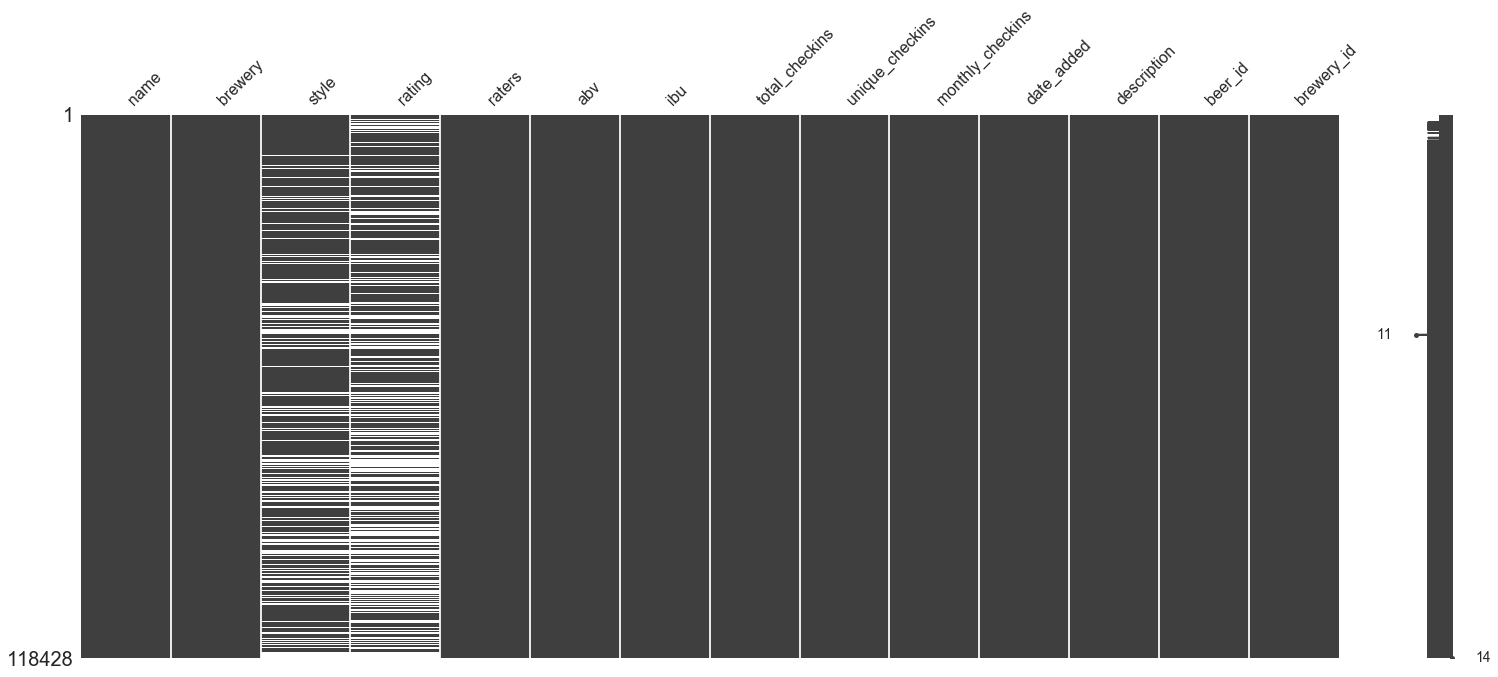

In [14]:
msno.matrix(beers_redux)

In [15]:
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118428 entries, 0 to 148912
Data columns (total 14 columns):
name                118428 non-null object
brewery             118427 non-null object
style               93403 non-null object
rating              74388 non-null object
raters              118428 non-null object
abv                 118428 non-null object
ibu                 118428 non-null object
total_checkins      118428 non-null object
unique_checkins     118428 non-null object
monthly_checkins    118428 non-null object
date_added          118428 non-null object
description         118428 non-null object
beer_id             118428 non-null int64
brewery_id          118428 non-null int64
dtypes: int64(2), object(12)
memory usage: 13.6+ MB


## Missing Rating Data

In [16]:
beers_redux['raters'] = beers_redux['raters'].apply(bleach)
### Let's go ahead and bleach some other stuff while we're here
beers_redux['total_checkins'] = beers_redux['total_checkins'].apply(bleach)
beers_redux['unique_checkins'] = beers_redux['unique_checkins'].apply(bleach)
beers_redux['monthly_checkins'] = beers_redux['monthly_checkins'].apply(bleach)

In [17]:
beers_redux['raters'].describe()

count    118428.000000
mean       6341.056988
std       28076.942676
min           0.000000
25%           3.000000
50%          49.000000
75%         871.250000
max      439454.000000
Name: raters, dtype: float64

In [18]:
beers_redux[beers_redux['raters'] < 10].shape

(44040, 14)

According to Untappd's website, a beer must have at least 10 ratings to have a rating displayed. It looks like that explains our missing rating data. 

We can't use this to build our model because we need to train the model on the existing rating, but it could make interesting test data.....

In [19]:
beers_redux = beers_redux[beers_redux['raters'] >= 10].copy()
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74388 entries, 0 to 148911
Data columns (total 14 columns):
name                74388 non-null object
brewery             74388 non-null object
style               73348 non-null object
rating              74388 non-null object
raters              74388 non-null float64
abv                 74388 non-null object
ibu                 74388 non-null object
total_checkins      74388 non-null float64
unique_checkins     74388 non-null float64
monthly_checkins    74388 non-null float64
date_added          74388 non-null object
description         74388 non-null object
beer_id             74388 non-null int64
brewery_id          74388 non-null int64
dtypes: float64(4), int64(2), object(8)
memory usage: 8.5+ MB


We are now missing much less style data. I suspect this is because beers with under 10 ratings may well be lower quality entries.

## Style Data

### Missing Data

In [20]:
beers_redux[beers_redux['style'].isnull()]

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id
1032,Pioneer Peak Porter,Great Bear Brewing,NaN,(2.75),12.0,\n 4.3% ABV ...,\n No IBU ...,23.0,22.0,0.0,\n Added 08/21/10 ...,,1097,601
6294,Oatmeal Stout,Cambrian Brewing Co,NaN,(3.66),14.0,\n No ABV ...,\n No IBU ...,28.0,22.0,0.0,\n Added 10/31/10 ...,,7024,1760
6617,Apricot IPA,Homebrew,NaN,(4.02),14.0,\n No ABV ...,\n No IBU ...,27.0,20.0,0.0,\n Added 11/05/10 ...,Dried apricots ad...,7376,1775
6888,Witbeir Homebrew,Homebrew,NaN,(3.99),17.0,\n No ABV ...,\n No IBU ...,42.0,27.0,0.0,\n Added 11/06/10 ...,,7662,1775
7054,Red Ale,Brewer's Best,NaN,(3.52),178.0,\n No ABV ...,\n No IBU ...,415.0,195.0,6.0,\n Added 09/24/11 ...,,81417,6713
7359,Northern Brewer Hefeweizen,Homebrew,NaN,(3.83),30.0,\n No ABV ...,\n No IBU ...,45.0,36.0,0.0,\n Added 11/09/10 ...,Light with a hint...,8159,1775
7550,Czech-Style Pilsner,Homebrew,NaN,(3.58),12.0,\n No ABV ...,\n No IBU ...,39.0,24.0,0.0,\n Added 11/10/10 ...,,8360,1775
7785,GIPA,Homebrew,NaN,(3.7),4449.0,\n 5.58% ABV ...,\n 70 IBU ...,9832.0,5212.0,0.0,\n Added 11/11/10 ...,,8604,1775
8266,Pain in the BIPA,GBGH Brewing,NaN,(3.77),13.0,\n No ABV ...,\n No IBU ...,47.0,34.0,0.0,\n Added 11/13/10 ...,,9104,2533
8751,Caribou Slobber,Homebrew,NaN,(3.7),372.0,\n 6.4% ABV ...,\n No IBU ...,777.0,444.0,0.0,\n Added 11/17/10 ...,My very first brew,9642,1775


In [21]:
beers_redux[beers_redux['style'].isnull()].brewery.value_counts()

Homebrew                                      244
Northern Brewer Homebrew Supply                67
Mr. Beer Home Brewery                          33
Brewer's Best                                  27
Midwest Supplies                               19
Brooklyn Brew Shop                             17
Coopers Brewery Limited - Homebrews            13
DaH Brew                                       11
Bargar Brewery                                  8
Vine Park Brewing Co                            6
Palindrome Brewing Company                      6
FIGJAM Brewing                                  5
Austin Homebrew Supply                          5
NBT Brewing                                     5
Midwest Homebrewing                             5
Hogshead Brewing (homebrew)                     5
Soma Ale Werks                                  4
Galaxy Brewing (Homebrew)                       4
Grandview Brewery                               4
Ratchet Brews                                   4


The *vast* majority of missing style data is from homebrews. Much of the style data appears to be present in the name column. I could hard code those styles.... but I'd rather figure out a way to do it programatically.

### Styles

In [22]:
beers_redux['style'].value_counts()

IPA - American                          4764
Pale Ale - American                     3188
Red Ale - American Amber / Red          2541
IPA - Imperial / Double                 2011
Hefeweizen                              1870
Lager - Pale                            1811
English Bitter                          1690
Saison / Farmhouse Ale                  1387
Stout - Other                           1377
Stout - American Imperial / Double      1365
Pilsner - Other                         1361
Brown Ale - American                    1294
Blonde Ale                              1258
Fruit Beer                              1244
Porter - Other                          1218
Golden Ale                              1215
Witbier                                 1196
Pale Ale - English                      1128
Cider                                   1082
Porter - American                       1058
Barleywine - American                   1007
Märzen                                   985
Belgian Tr

In [23]:
beers_redux['style'].value_counts().shape

(167,)

This categorical variable looks super valuable. However, some of the styles have too few examples to be meaningfully used. 

I see a couple different options: 
I could create a set of umbrella categories--> Something as simple as [ale, lager, wild] might be useful or perhaps [mainstream style, uncommon style]
-----> It appers a great many of the categories have parent styles included before the dash
I could also siphon off rarer styles into its own umbrella 

## BREWERIES

In [24]:
beers_redux.brewery.value_counts()

Rock Bottom Restaurant & Brewery                           414
Mikkeller                                                  374
Dogfish Head Craft Brewery                                 363
Iron Hill Brewery & Restaurant                             276
Stone Brewing                                              258
Sierra Nevada Brewing Co.                                  256
Homebrew                                                   244
Boston Beer Company                                        243
Lagunitas Brewing Company                                  243
Cigar City Brewing                                         235
Rogue Ales & Spirits                                       234
Bell's Brewery                                             230
Avery Brewing Co.                                          227
New Belgium Brewing Company                                199
Guinness                                                   199
Founders Brewing Co.                                   

In [25]:
beers_redux.brewery.value_counts().shape

(7224,)

In [26]:
beers_redux.brewery.value_counts()[beers_redux.brewery.value_counts() == 1].shape

(2038,)

*A LOT* of one-offs. This is part of why incorporating info from the brewery table will be so valuable.

## Beer IDs
I'm interested in checking this out to see how high the number goes, b/c I am scraping based on this number.

In [27]:
beers_redux.beer_id.describe()

count    7.438800e+04
mean     8.800058e+04
std      1.471047e+05
min      1.000000e+00
25%      1.807450e+04
50%      5.646250e+04
75%      1.100995e+05
max      2.030279e+06
Name: beer_id, dtype: float64

In [28]:
beers_redux.beer_id.sort_values(ascending=False)

142156    2030279
52715     2018642
50315     1976011
49316     1960261
27966     1946713
91916     1940143
32674     1928453
132214    1928453
3594      1928453
111319    1928453
23283     1922097
23533     1904065
101071    1884111
91705     1878506
148888    1875643
132594    1872887
98481     1852477
13761     1849960
11418     1845238
146016    1843260
98599     1843260
142921    1843260
12774     1843260
115277    1843260
11008     1840728
140460    1828113
64704     1823588
98831     1821361
91230     1816249
2900      1811069
88193     1806166
48586     1803704
39133     1803704
75000     1797842
14932     1794727
97216     1793300
31714     1791701
89814     1791225
13723     1788928
73314     1788382
50448     1770242
63025     1767674
78771     1757368
92351     1756057
78302     1755361
117054    1751903
139381    1749978
45289     1745924
24937     1744919
76955     1743652
25147     1730270
19977     1724253
122938    1722797
70968     1722797
66056     1718256
42243     

## Rating

In [29]:
beers_redux['rating'] = beers_redux['rating'].apply(bleach)

In [30]:
beers_redux['rating'].describe()

count    74388.000000
mean         3.501883
std          0.365923
min          1.020000
25%          3.320000
50%          3.520000
75%          3.720000
max          4.940000
Name: rating, dtype: float64

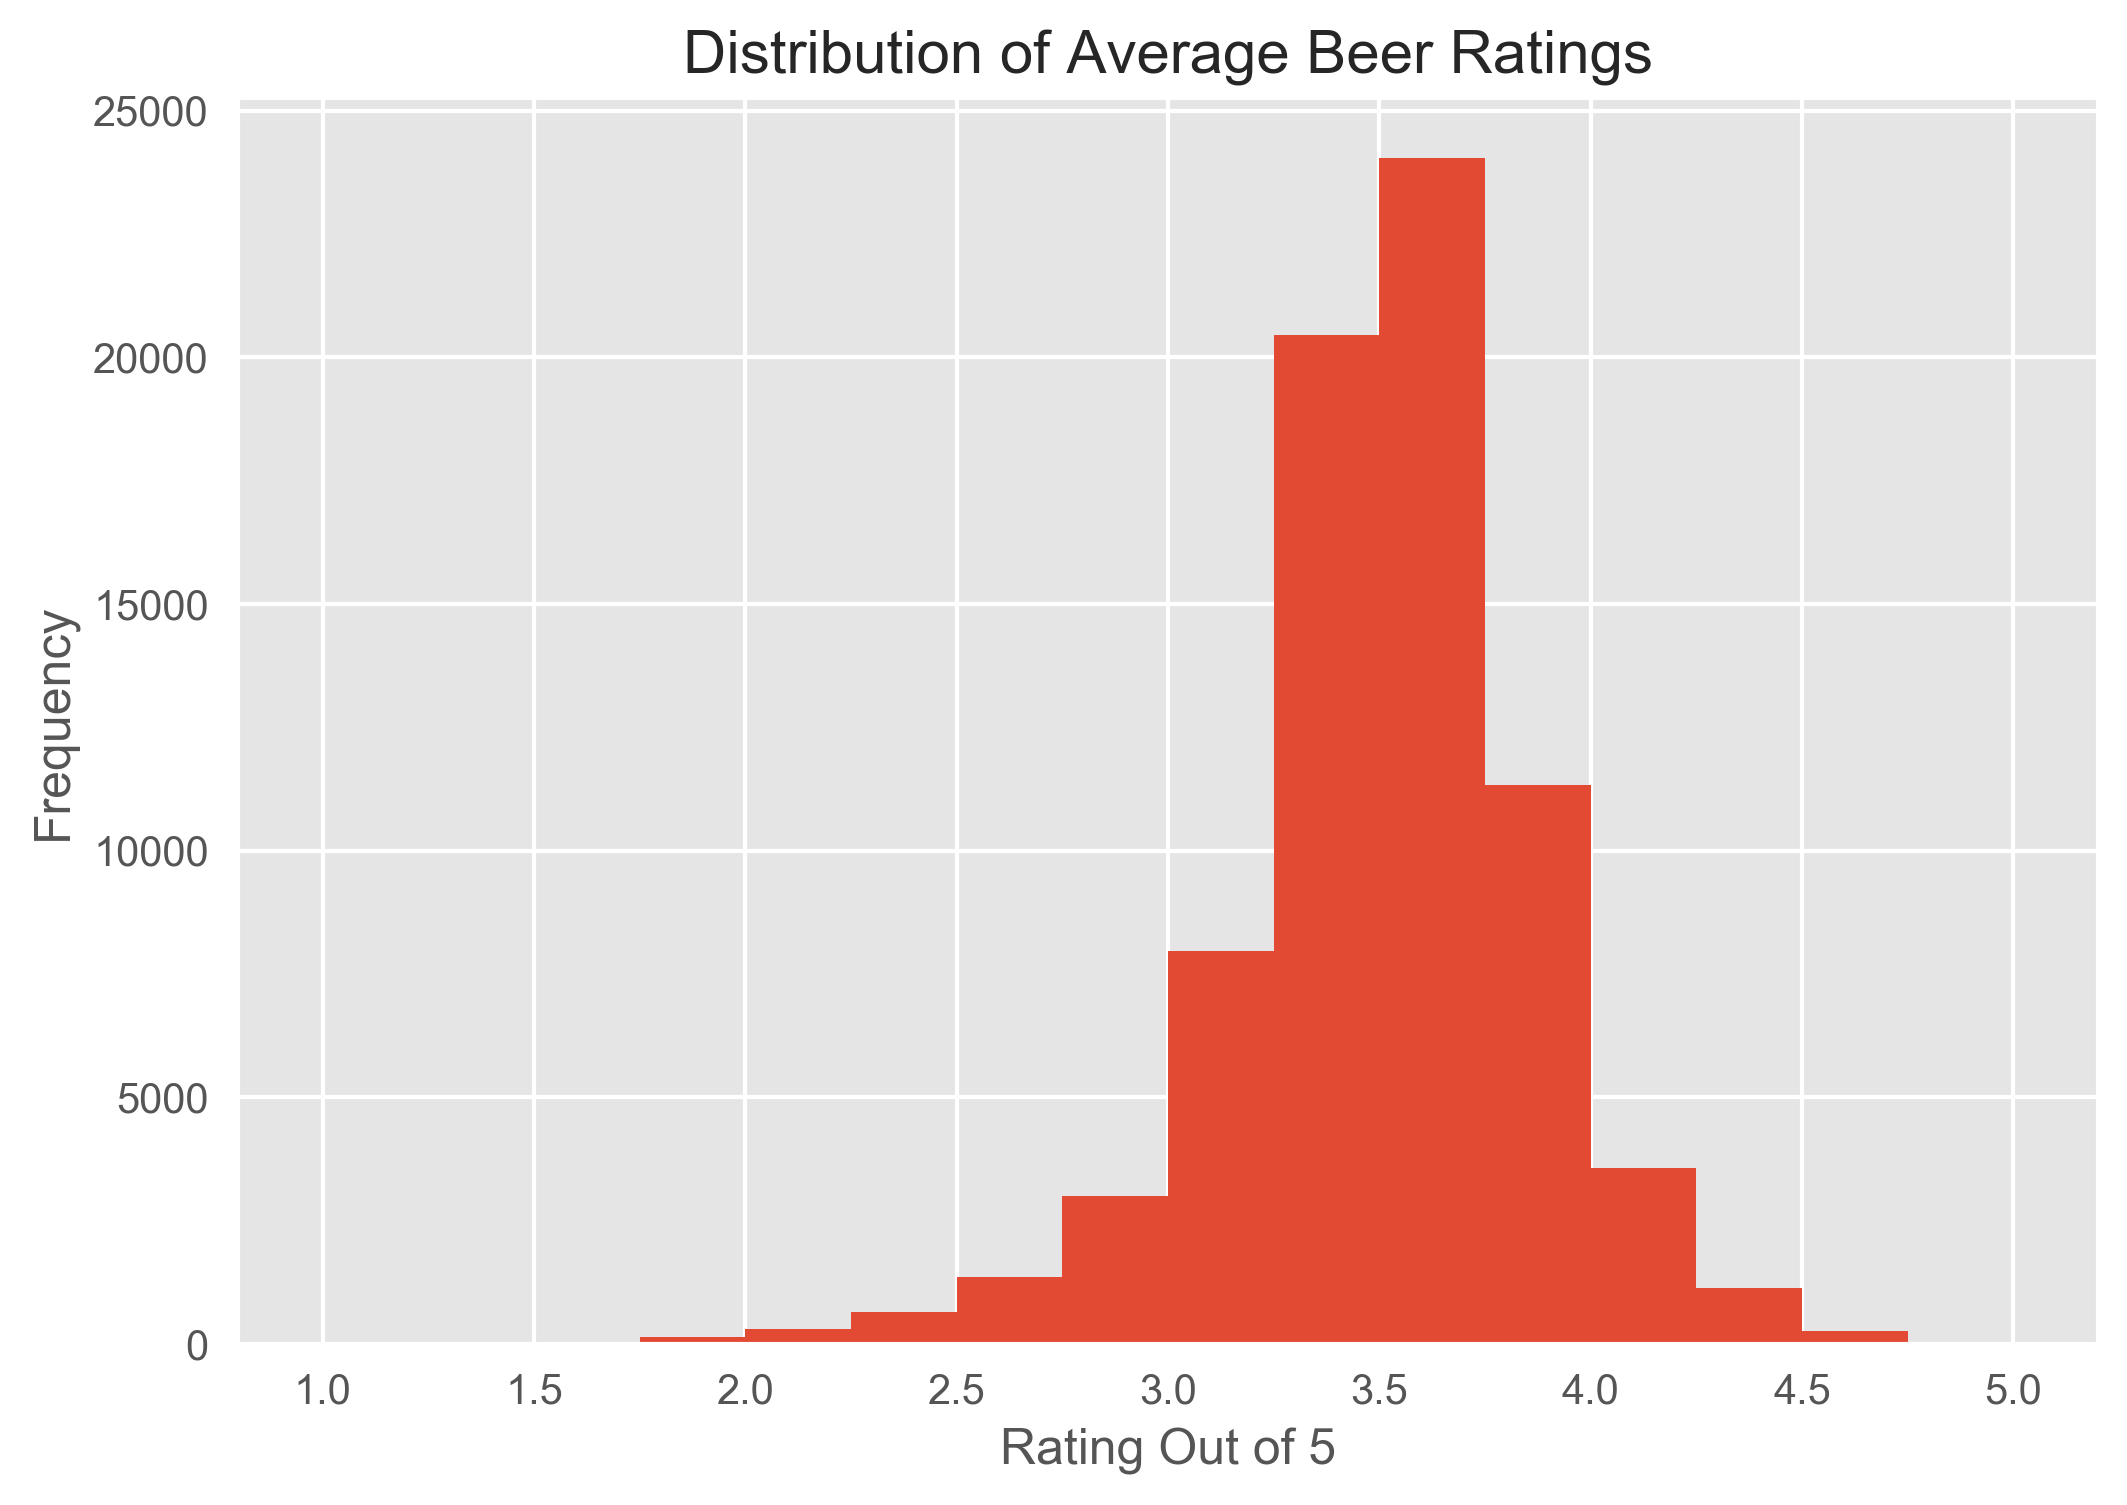

In [31]:
fig = plt.figure(dpi=300)
plt.style.use('ggplot')
plt.hist(beers_redux['rating'], bins = np.arange(1,5.25,.25))
plt.xlabel('Rating Out of 5')
plt.ylabel('Frequency')
plt.title('Distribution of Average Beer Ratings')

Fairly normally distributed, but skewed to the left. Centered around 3.5.

## ABV

In [32]:
beers_redux['abv'] = beers_redux['abv'].apply(bleach)

In [33]:
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74388 entries, 0 to 148911
Data columns (total 14 columns):
name                74388 non-null object
brewery             74388 non-null object
style               73348 non-null object
rating              74388 non-null float64
raters              74388 non-null float64
abv                 68106 non-null float64
ibu                 74388 non-null object
total_checkins      74388 non-null float64
unique_checkins     74388 non-null float64
monthly_checkins    74388 non-null float64
date_added          74388 non-null object
description         74388 non-null object
beer_id             74388 non-null int64
brewery_id          74388 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 8.5+ MB


As I expected, some of the ABV data is missing now that it has been cleaned (about 6% on this run). For this and IBU, imputing the median might be a reasonable move. Alternatively, we might impute the median for these values for the particular style of beer? Probably would have a greater influence on IBU than ABV. That said, if the median abv is 5.0 and we impute that for a Triple IPA, it would skew that data point pretty hard....

For the sake of checking out the distribution, I'm just gonna do the median for the time being.

In [34]:
beers_redux['abv'].describe()

count    68106.000000
mean         6.406489
std          7.989657
min          0.050000
25%          5.000000
50%          5.800000
75%          7.322500
max       2011.000000
Name: abv, dtype: float64

In [35]:
beers_redux['abv'].fillna(5.8, inplace=True)

In [36]:
beers_redux['abv'].describe()

count    74388.000000
mean         6.355271
std          7.646713
min          0.050000
25%          5.000000
50%          5.800000
75%          7.000000
max       2011.000000
Name: abv, dtype: float64

In [37]:
beers_redux[beers_redux['abv'] > 20]

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id
1286,Samuel Adams Utopias,Boston Beer Company,Strong Ale - American,4.48,11070.0,27.0,\n No IBU ...,14276.0,12893.0,129.0,\n Added 12/30/10 ...,Truly the epitome...,19004,157
5056,Tactical Nuclear Penguin,BrewDog,Stout - American Imperial / Double,3.90,8908.0,32.0,\n 90 IBU ...,12135.0,10319.0,96.0,\n Added 08/21/10 ...,No Penguins were...,5713,241
5357,Sink The Bismarck!,BrewDog,IPA - Imperial / Double,3.69,8561.0,41.0,\n No IBU ...,11304.0,10008.0,135.0,\n Added 10/03/10 ...,An unsettling dev...,6039,241
5358,The End of History,BrewDog,Belgian Strong Golden Ale,3.92,106.0,55.0,\n No IBU ...,150.0,149.0,1.0,\n Added 10/03/10 ...,The End of Histor...,6040,241
8278,Schorschbock 43,Schorschbräu,Bock,3.91,19.0,43.0,\n No IBU ...,36.0,34.0,0.0,\n Added 11/13/10 ...,,9122,2540
10641,\n Samuel A...,Boston Beer Company,Strong Ale - American,4.58,221.0,24.0,\n No IBU ...,324.0,282.0,1.0,\n Added 11/27/10 ...,,11595,157
12074,Belligerent Ass Nut Brown Ale,Portneuf Valley Brewing,Brown Ale - American,3.55,342.0,28.0,\n 4 IBU ...,415.0,381.0,8.0,\n Added 12/06/10 ...,"A smooth, nutty, ...",13080,3507
13899,\n Samuel A...,Boston Beer Company,Strong Ale - American,4.57,1418.0,27.0,\n No IBU ...,2070.0,1684.0,29.0,\n Added 01/27/11 ...,Truly the epitome...,26769,157
16134,Schorschbock 31,Schorschbräu,Doppelbock,3.29,46.0,31.0,\n No IBU ...,60.0,59.0,0.0,\n Added 12/26/10 ...,,17410,2540
17910,\n Samuel A...,Boston Beer Company,Strong Ale - American,4.60,621.0,27.0,\n No IBU ...,907.0,773.0,6.0,\n Added 12/30/10 ...,,19265,157


In [38]:
beers_redux.drop(97254, axis=0, inplace=True)

In [39]:
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74387 entries, 0 to 148911
Data columns (total 14 columns):
name                74387 non-null object
brewery             74387 non-null object
style               73348 non-null object
rating              74387 non-null float64
raters              74387 non-null float64
abv                 74387 non-null float64
ibu                 74387 non-null object
total_checkins      74387 non-null float64
unique_checkins     74387 non-null float64
monthly_checkins    74387 non-null float64
date_added          74387 non-null object
description         74387 non-null object
beer_id             74387 non-null int64
brewery_id          74387 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 8.5+ MB


([<matplotlib.axis.XTick at 0x118d64208>,
 <a list of 20 Text xticklabel objects>)

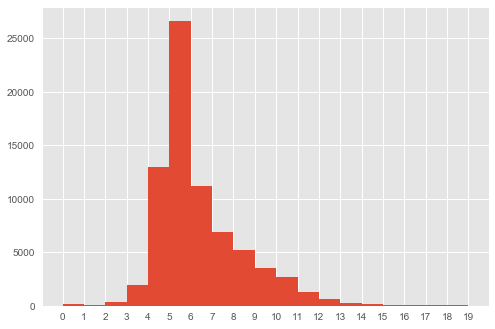

In [40]:
plt.hist(
    beers_redux['abv'].values, bins=range(0, 20, 1),
)
plt.xticks(np.arange(0, 20, 1.0))

In [41]:
len(beers_redux)

74387

## IBU

In [42]:
beers_redux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74387 entries, 0 to 148911
Data columns (total 14 columns):
name                74387 non-null object
brewery             74387 non-null object
style               73348 non-null object
rating              74387 non-null float64
raters              74387 non-null float64
abv                 74387 non-null float64
ibu                 74387 non-null object
total_checkins      74387 non-null float64
unique_checkins     74387 non-null float64
monthly_checkins    74387 non-null float64
date_added          74387 non-null object
description         74387 non-null object
beer_id             74387 non-null int64
brewery_id          74387 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 8.5+ MB


So, only about a third of our beers have inputted IBU data. This in itself could be a feature...

In [43]:
beers_redux['ibu'] = beers_redux['ibu'].apply(bleach)
beers_redux['ibu'].fillna(0, inplace=True)

In [43]:
beers_redux.ibu.describe()

count                                                 74387
unique                                                  172
top       \n                        No IBU              ...
freq                                                  50067
Name: ibu, dtype: object

This dataframe reveals that some of the duplicates have escaped notice. Perhaps I should drop on just the 'beer_id'.

In [45]:
beers_redux.shape

(74387, 14)

In [46]:
beers_redux[beers_redux.duplicated(subset='beer_id')].shape

(15868, 14)

Looks like I definitely need to be dropping on the id number

In [47]:
beers_model = beers_redux.drop_duplicates(subset='beer_id')
beers_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58519 entries, 0 to 148903
Data columns (total 14 columns):
name                58519 non-null object
brewery             58519 non-null object
style               57488 non-null object
rating              58519 non-null float64
raters              58519 non-null float64
abv                 58519 non-null float64
ibu                 58519 non-null object
total_checkins      58519 non-null float64
unique_checkins     58519 non-null float64
monthly_checkins    58519 non-null float64
date_added          58519 non-null object
description         58519 non-null object
beer_id             58519 non-null int64
brewery_id          58519 non-null int64
dtypes: float64(6), int64(2), object(6)
memory usage: 6.7+ MB


In [48]:
beers_model.corr()

,rating,raters,abv,total_checkins,unique_checkins,monthly_checkins,beer_id,brewery_id
rating,1.000000,0.057105,0.481154,0.037338,0.054333,0.028679,0.000969,-0.011732
raters,0.057105,1.000000,0.021750,0.949571,0.999584,0.702048,-0.067130,-0.002427
abv,0.481154,0.021750,1.000000,0.008784,0.020577,0.001401,-0.014088,-0.002177
total_checkins,0.037338,0.949571,0.008784,1.000000,0.954189,0.775123,-0.054833,-0.001842
unique_checkins,0.054333,0.999584,0.020577,0.954189,1.000000,0.704581,-0.067441,-0.002421
monthly_checkins,0.028679,0.702048,0.001401,0.775123,0.704581,1.000000,-0.032945,-0.001237
beer_id,0.000969,-0.067130,-0.014088,-0.054833,-0.067441,-0.032945,1.000000,0.001060
brewery_id,-0.011732,-0.002427,-0.002177,-0.001842,-0.002421,-0.001237,0.001060,1.000000


# Importing Brewery Data

In [49]:
breweries = pd.read_csv('data/master_untappd_brewery_data.csv')

In [50]:
breweries.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'brewery_account_status',
       'brewery_description', 'brewery_id', 'brewery_location', 'brewery_name',
       'brewery_num_beers', 'brewery_raters', 'brewery_rating', 'brewery_type',
       'date_brewery_added', 'monthly_brewery_checkins', 'subsidiary_id',
       'subsidiary_name', 'total_brewery_checkins', 'unique_brewery_checkins'],
      dtype='object')

In [51]:
breweries = breweries[['brewery_id', 'brewery_name', 'brewery_type', 'brewery_account_status',
       'brewery_description', 'brewery_location', 
       'brewery_num_beers', 'brewery_raters', 'brewery_rating', 
       'date_brewery_added', 'monthly_brewery_checkins', 'subsidiary_id',
       'subsidiary_name', 'total_brewery_checkins', 'unique_brewery_checkins']].copy()

In [52]:
breweries.brewery_id.describe()

count     15125.000000
mean      19379.096661
std       28049.724262
min           4.000000
25%        8670.000000
50%       16089.000000
75%       23083.000000
max      331430.000000
Name: brewery_id, dtype: float64

In [53]:
breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15125 entries, 0 to 15124
Data columns (total 15 columns):
brewery_id                  15125 non-null int64
brewery_name                15125 non-null object
brewery_type                15125 non-null object
brewery_account_status      15125 non-null object
brewery_description         15125 non-null object
brewery_location            15125 non-null object
brewery_num_beers           15125 non-null object
brewery_raters              15125 non-null object
brewery_rating              7799 non-null object
date_brewery_added          15125 non-null object
monthly_brewery_checkins    15125 non-null object
subsidiary_id               481 non-null object
subsidiary_name             481 non-null object
total_brewery_checkins      15125 non-null object
unique_brewery_checkins     15125 non-null object
dtypes: int64(1), object(14)
memory usage: 1.7+ MB


In [54]:
joined = pd.merge(beers_model, breweries, how='left', on=['brewery_id', 'brewery_id'])
joined.head()

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,...,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins
0,Hocus Pocus,Magic Hat Brewing Company,Pale Wheat Ale - American,3.23,10365.0,4.5,\n 13 IBU ...,14835.0,12168.0,99.0,...,"\n\t\t\t\t\t\t\t\tSouth Burlington, VT \t\t\t\...",70 Beers,"\n\t\t\t\t\t\t965,599 Ratings\t\t\t\t\t",(3.41),\n\t\t\t\t\t\tAdded 10/03/10\t\t\t\t\t,"11,376","[195747, 2336]","['Florida Ice and Farm Company S.A.', 'Cervece...",1.46M+,"372,439"
1,Grimbergen Blonde,Brouwerij Alken-Maes,Blonde Ale - Belgian Blonde / Golden,3.51,61846.0,6.7,\n 22 IBU ...,92563.0,68879.0,2144.0,...,"\n\t\t\t\t\t\t\t\tMechelen, Antwerpen \t\t\t\t...",57 Beers,"\n\t\t\t\t\t\t254,798 Ratings\t\t\t\t\t",(3.45),\n\t\t\t\t\t\tAdded 10/12/10\t\t\t\t\t,"9,581","[1400, 344]","['Heineken', 'Carlsberg Group']","372,388","144,274"
2,Widdershins Oak Aged Barleywine Ale,Left Hand Brewing Company,Barleywine - English,3.69,4735.0,10.7,\n 65 IBU ...,5859.0,5444.0,7.0,...,"\n\t\t\t\t\t\t\t\tLongmont, CO \t\t\t\t\t\t\t\...",334 Beers,"\n\t\t\t\t\t\t1,066,392 Ratings\t\t\t\t\t",(3.74),\n\t\t\t\t\t\tAdded 10/03/10\t\t\t\t\t,"25,284",NaN,NaN,1.56M+,"458,037"
3,Lucifer,Brouwerij Het Anker,Belgian Strong Golden Ale,3.60,28866.0,8.0,\n 24 IBU ...,36667.0,32498.0,551.0,...,"\n\t\t\t\t\t\t\t\tMechelen, Antwerpen \t\t\t\t...",29 Beers,"\n\t\t\t\t\t\t276,020 Ratings\t\t\t\t\t",(3.78),\n\t\t\t\t\t\tAdded 10/08/10\t\t\t\t\t,"9,938",NaN,NaN,"365,984","145,970"
4,Oxfordshire Bitter,Ridgeway Brewing,English Bitter,3.29,547.0,4.0,\n No IBU ...,704.0,645.0,6.0,...,\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tEngland\t\t\...,41 Beers,"\n\t\t\t\t\t\t81,883 Ratings\t\t\t\t\t",(3.34),\n\t\t\t\t\t\tAdded 10/11/10\t\t\t\t\t,586,NaN,NaN,"97,056","54,908"


In [55]:
joined.brewery_id.describe()

count    5.851900e+04
mean     2.211183e+05
std      1.679011e+07
min      4.000000e+00
25%      1.358000e+03
50%      3.713000e+03
75%      9.893500e+03
max      2.000212e+09
Name: brewery_id, dtype: float64

In [56]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58519 entries, 0 to 58518
Data columns (total 28 columns):
name                        58519 non-null object
brewery                     58519 non-null object
style                       57488 non-null object
rating                      58519 non-null float64
raters                      58519 non-null float64
abv                         58519 non-null float64
ibu                         58519 non-null object
total_checkins              58519 non-null float64
unique_checkins             58519 non-null float64
monthly_checkins            58519 non-null float64
date_added                  58519 non-null object
description                 58519 non-null object
beer_id                     58519 non-null int64
brewery_id                  58519 non-null int64
brewery_name                57959 non-null object
brewery_type                57959 non-null object
brewery_account_status      57959 non-null object
brewery_description         57959 non

In [57]:
joined.brewery_type.value_counts()
joined.brewery_type.fillna('Micro Brewery', inplace=True)
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58519 entries, 0 to 58518
Data columns (total 28 columns):
name                        58519 non-null object
brewery                     58519 non-null object
style                       57488 non-null object
rating                      58519 non-null float64
raters                      58519 non-null float64
abv                         58519 non-null float64
ibu                         58519 non-null object
total_checkins              58519 non-null float64
unique_checkins             58519 non-null float64
monthly_checkins            58519 non-null float64
date_added                  58519 non-null object
description                 58519 non-null object
beer_id                     58519 non-null int64
brewery_id                  58519 non-null int64
brewery_name                57959 non-null object
brewery_type                58519 non-null object
brewery_account_status      57959 non-null object
brewery_description         57959 non

Probably makes sense to use get_dummes for this (labelencoder for a pipeline)

In [58]:
joined = joined.join(pd.get_dummies(joined['style']))

In [59]:
joined = joined.join(pd.get_dummies(joined['brewery_type']))

In [60]:
styles = joined['style'].value_counts().index[0:]

In [61]:
joined['brewery_account_status'].value_counts()

Official              39639
presumed_unclaimed    18320
Name: brewery_account_status, dtype: int64

In [62]:
joined['brewery_account_status'] = joined['brewery_account_status'].apply(lambda x: 1 if x == 'Official' else 0)

In [63]:
joined['brewery_num_beers'] = joined['brewery_num_beers'].apply(bleach)
joined['brewery_num_beers'] = joined['brewery_num_beers'].apply(bleach)
joined['brewery_num_beers'] = joined['brewery_num_beers'].apply(bleach)
joined['brewery_num_beers'] = joined['brewery_num_beers'].apply(bleach)

In [64]:
joined['ibu']

0        \n                        13 IBU              ...
1        \n                        22 IBU              ...
2        \n                        65 IBU              ...
3        \n                        24 IBU              ...
4        \n                        No IBU              ...
5        \n                        No IBU              ...
6        \n                        No IBU              ...
7        \n                        32 IBU              ...
8        \n                        33 IBU              ...
9        \n                        20 IBU              ...
10       \n                        No IBU              ...
11       \n                        35 IBU              ...
12       \n                        No IBU              ...
13       \n                        20 IBU              ...
14       \n                        52 IBU              ...
15       \n                        No IBU              ...
16       \n                        90 IBU              .

## First Model

In [65]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [66]:
y = joined.rating.values

features = ['total_checkins', 'abv', 'brewery_account_status', 'Bar / Restaurant / Store', 'Brew Pub', 'Cidery / Meadery',
       'Home Brewery', 'Macro Brewery', 'Micro Brewery', 'Nano Brewery']
for beer_style in styles:
    features.append(beer_style)

x = joined[features].values

In [67]:
x = StandardScaler().fit_transform(x)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [69]:
print(y_train.shape)
y_test.shape

(43889,)


(14630,)

In [70]:
linreg = LinearRegression()

In [71]:
linreg.fit(x_train, y_train)
linreg.score(x_train, y_train)

0.51993372811874661

In [72]:
linreg.score(x_test, y_test)

0.52040523010346718

In [73]:
predictions = linreg.predict(x_test)

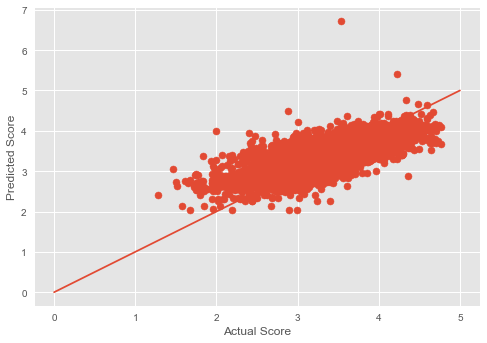

In [74]:
plt.scatter(y_test, predictions)
plt.ylabel('Predicted Score')
plt.xlabel('Actual Score')
plt.plot([0,5], [0,5])
plt.show()

Unsurprising graph, especially since there are some serious outliers in terms of ABV

In [75]:
def run_model(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    print(model)
    print("Training set score: ", model.score(x_train, y_train))
    print("Test set score: ", model.score(x_test, y_test))
    predictions = model.predict(x_test)
    plt.scatter(y_test, predictions)
    plt.ylabel('Predicted Score')
    plt.xlabel('Actual Score')
    plt.plot([0,5], [0,5])
    plt.show()
    plt.clf()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Training set score:  0.519933728119
Test set score:  0.520405230103


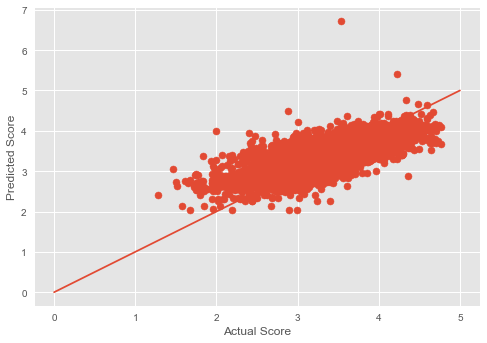

In [76]:
run_model(x_train, x_test, y_train, y_test, linreg)

In [77]:
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
en = ElasticNet()
br = BayesianRidge()
rfr = RandomForestRegressor(n_jobs=-1)
etr = ExtraTreesRegressor(n_jobs=-1)
ada = AdaBoostRegressor()
gbr = GradientBoostingRegressor()

models = [lr, lasso, ridge, en, br, rfr, etr, gbr, ada]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Training set score:  0.519933728119
Test set score:  0.520405230103


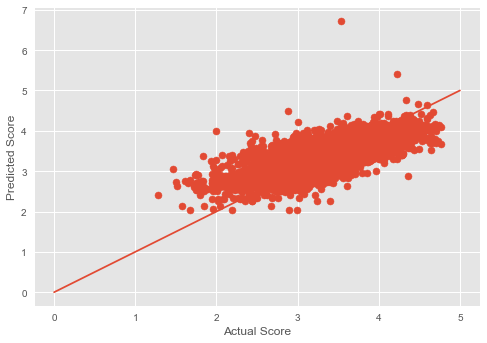

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
Training set score:  0.0
Test set score:  -0.000229867524633


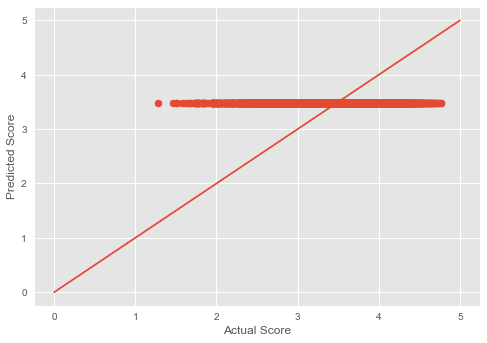

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Training set score:  0.519974622357
Test set score:  0.520443473315


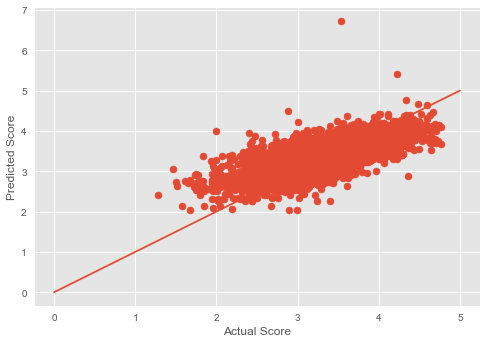

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Training set score:  0.0
Test set score:  -0.000229867524633


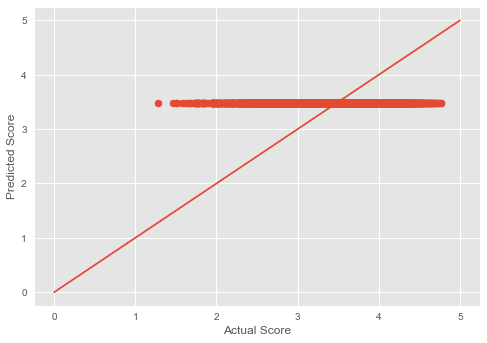

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
Training set score:  0.519889302089
Test set score:  0.520505734671


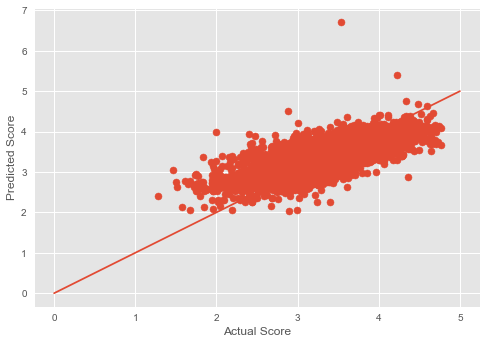

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Training set score:  0.915129278683
Test set score:  0.465235194737


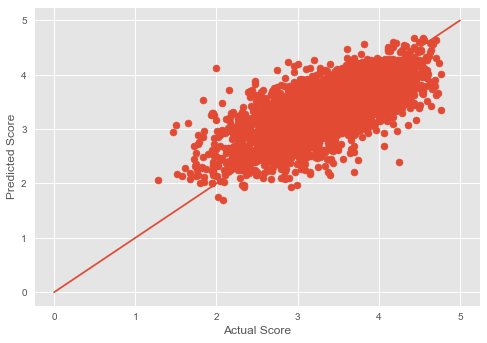

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
Training set score:  0.985674653163
Test set score:  0.320936286156


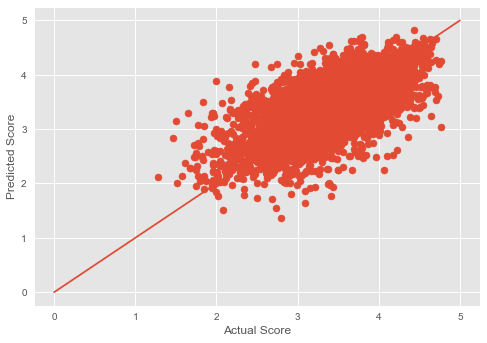

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
Training set score:  0.502369601608
Test set score:  0.498351586016


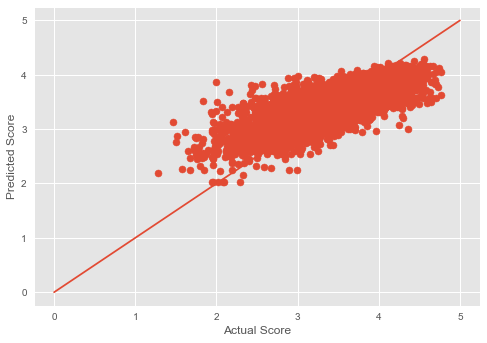

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)
Training set score:  0.235829584658
Test set score:  0.240341076831


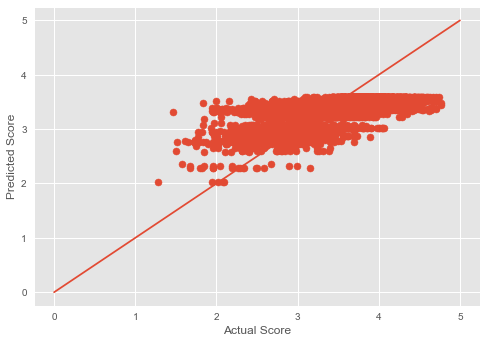

In [ ]:
for model in models:
    run_model(x_train, x_test, y_train, y_test, model)

### Summary:
Linear Regression, Bayesian Ridge, and Gradient Boosting are all performing well with test r^2 scores of around 0.5. That sets a nice benchmark for us to build on. Next steps will be feature engineering and pipeline construction in order to more easily iterate around features and model parameters.